# Paper

https://ieeexplore.ieee.org/abstract/document/9519428?casa_token=RoZCE-WI7asAAAAA:3AsNvVmcatupCfR0sF_32xV1s6S5-uRMC4JU8zovlerPiaYR2G64rOaTTgoC3mhag_iHmmaVaB8

O pipeline utiliza o framework SISA com RandomForestClassifier e embeddings do BERT para classificar textos com alta precisão, enquanto garante a privacidade dos dados por meio de machine unlearning. O BERT extrai representações contextuais robustas, o RF classifica essas representações de forma eficiente, e o SISA permite remover dados específicos rapidamente, retreinando apenas os shards afetados. Testes empíricos mostram que as predições após o unlearning são consistentes com um modelo treinado sem os dados removidos,  atendendo a requisitos de privacidade como o GDPR

#referencias principais

https://ieeexplore.ieee.org/abstract/document/9519428?casa_token=RoZCE-WI7asAAAAA:3AsNvVmcatupCfR0sF_32xV1s6S5-uRMC4JU8zovlerPiaYR2G64rOaTTgoC3mhag_iHmmaVaB8

https://aclanthology.org/2022.lrec-1.777/

https://www.cambridge.org/core/journals/natural-language-processing/article/contextaware-and-expert-data-resources-for-brazilian-portuguese-hate-speech-detection/7D9019ED5471CD16E320EBED06A6E923#}

https://aclanthology.org/2025.coling-main.446/

https://www.tandfonline.com/doi/full/10.1080/01431160412331269698

#Justificativa

Justificativa técnica
A escolha do SISA com RF e BERT é justificada pelos seguintes pontos:

* BERT: Fornece embeddings state-of-the-art para textos, capturando relações semânticas complexas que outros métodos (e.g., TF-IDF) não conseguem. Sua pré-computação (salva com save_embeddings) garante eficiência em pipelines iterativos.
* RandomForestClassifier: É ideal para embeddings de alta dimensionalidade (768 dimensões do BERT) devido à sua capacidade de lidar com features correlacionadas e sua natureza ensemble, que reduz overfitting. Além disso, RFs são compatíveis com o SISA, pois podem ser treinados independentemente em cada shard.
* SISA: Oferece uma solução prática para machine unlearning, essencial em cenários onde a privacidade é crítica. O paper Machine Unlearning (Bourtoule et al., 2021) demonstra que o SISA reduz significativamente o tempo de unlearning (e.g., até 4.63x para o dataset Purchase), tornando-o adequado para aplicações reais.

In [ ]:
%%capture
!pip install transformers torch scikit-learn pandas numpy datasets

#Importação dos pacotes


In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import mode
import time


In [ ]:
from datetime import datetime
import os
from google.colab import drive

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

# Carga do dataset

$$
\begin{array}{|l|c|r|}
\hline
\textbf{Anotação} & \textbf{Rótulo} & \textbf{Total} \\
\hline
\text{Ofensiva} & 1 & 3.500 \\
\text{Não ofensivo} & 0 & 3.500 \\
\hline
\textbf{Total} & & \textbf{7.000} \\
\hline
\end{array}
$$

In [ ]:
df_hateBr= pd.read_csv("/content/HateBR.csv")

In [ ]:
df_hateBr

,id,comentario,anotator1,anotator2,anotator3,label_final,links_post,account_post
0,1,Mais um lixo,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
1,2,Essa nao tem vergonha na cara!!,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
2,3,Essa mulher é doente.pilantra!,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
3,4,Comunista safada...,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
4,5,Vagabunda. Comunista. Mentirosa. O povo chilen...,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
...,...,...,...,...,...,...,...,...
6995,6996,Parabéns Eduardo!!! Deus te proteja. Obrigada ...,0,0,0,0,https://www.instagram.com/p/C5rDlbTPTJq/,Eduardo Bolsonaro
6996,6997,A melhor maneira de unir a direita do mundo to...,0,0,0,0,https://www.instagram.com/p/C5rDlbTPTJq/,Eduardo Bolsonaro
6997,6998,Vcs são lutadores. Sejam protegidos.,0,0,0,0,https://www.instagram.com/p/C5rDlbTPTJq/,Eduardo Bolsonaro
6998,6999,"Parabéns Deus abençoe 🙌, que a verdade traga a...",0,0,0,0,https://www.instagram.com/p/C5rDlbTPTJq/,Eduardo Bolsonaro


In [ ]:
df_hateBrXplain= pd.read_csv("/content/HateBRXplain.csv")

In [ ]:
df_hateBrXplain

,id,comment,offensive_label,link_post,rationales_annotator1,rationales_annotator2
0,1,Mais um lixo,1,https://www.instagram.com/p/B2uThqdH9xI/,Mais um lixo,mais um lixo
1,2,Essa nao tem vergonha na cara!!,1,https://www.instagram.com/p/B2uThqdH9xI/,Essa nao tem vergonha na cara,nao tem vergonha na cara
2,3,Essa mulher é doente.pilantra!,1,https://www.instagram.com/p/B2uThqdH9xI/,doente; pilantra,doente; pilantra
3,4,Comunista safada...,1,https://www.instagram.com/p/B2uThqdH9xI/,Comunista safada,comunista; safada
4,5,Vagabunda. Comunista. Mentirosa. O povo chilen...,1,https://www.instagram.com/p/B2uThqdH9xI/,Vagabunda. Comunista. Mentirosa; desgraça desta,comunista; mentirosa; nao merece uma desgraça ...
...,...,...,...,...,...,...
6995,6996,Parabéns Eduardo!!! Deus te proteja. Obrigada ...,0,https://www.instagram.com/p/C5rDlbTPTJq/,NaN,NaN
6996,6997,A melhor maneira de unir a direita do mundo to...,0,https://www.instagram.com/p/C5rDlbTPTJq/,NaN,NaN
6997,6998,Vcs são lutadores. Sejam protegidos.,0,https://www.instagram.com/p/C5rDlbTPTJq/,NaN,NaN
6998,6999,"Parabéns Deus abençoe 🙌, que a verdade traga a...",0,https://www.instagram.com/p/C5rDlbTPTJq/,NaN,NaN


In [ ]:
df_hateBr.account_post.unique()

array(['Carla Zambelli', 'Eduardo Bolsonaro', 'Fernando Haddad',
       "Manuela d'Ávila", 'Gleisi Hoffmann', 'Joice Hasselmann'],
      dtype=object)

In [ ]:
df_hateBr.groupby('account_post').count()

,id,comentario,anotator1,anotator2,anotator3,label_final,links_post
account_post,,,,,,,
Carla Zambelli,1481,1481,1481,1481,1481,1481,1481
Eduardo Bolsonaro,1151,1151,1151,1151,1151,1151,1151
Fernando Haddad,1118,1118,1118,1118,1118,1118,1118
Gleisi Hoffmann,834,834,834,834,834,834,834
Joice Hasselmann,1158,1158,1158,1158,1158,1158,1158
Manuela d'Ávila,1258,1258,1258,1258,1258,1258,1258


In [ ]:
df_hateBr[df_hateBr['label_final']==1].groupby('account_post').count()

,id,comentario,anotator1,anotator2,anotator3,label_final,links_post
account_post,,,,,,,
Carla Zambelli,990,990,990,990,990,990,990
Eduardo Bolsonaro,414,414,414,414,414,414,414
Fernando Haddad,264,264,264,264,264,264,264
Gleisi Hoffmann,439,439,439,439,439,439,439
Joice Hasselmann,695,695,695,695,695,695,695
Manuela d'Ávila,698,698,698,698,698,698,698


In [ ]:
df_hateBr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            7000 non-null   int64 
 1   comentario    7000 non-null   object
 2   anotator1     7000 non-null   int64 
 3   anotator2     7000 non-null   int64 
 4   anotator3     7000 non-null   int64 
 5   label_final   7000 non-null   int64 
 6   links_post    7000 non-null   object
 7   account_post  7000 non-null   object
dtypes: int64(5), object(3)
memory usage: 437.6+ KB


# Dividindo em treino e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_hateBr['comentario'].tolist(), df_hateBr['label_final'].tolist(), test_size=0.2, random_state=42, stratify=df_hateBr['label_final'].tolist()
)

In [ ]:
print(f"\n{len(X_train)} amostras de treino, {len(X_test)} amostras de teste.")


5600 amostras de treino, 1400 amostras de teste.


#Carregando modelo de lingaguem (BERTimbau)

In [ ]:
MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
MAX_LENGTH = 512
BATCH_SIZE = 16
VERSION = 'v1'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.52.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 29794
}

#mover modelo para GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29794, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

#Função para gerar Embeddings

In [ ]:
def get_bert_embeddings_batch(texts, batch_size=32):
    model.eval()
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.extend(cls_embeddings)
    return np.array(all_embeddings)

# Função para salvar embeddings

In [ ]:
drive.mount('/content/drive')
SAVE_DIR = '/content/drive/MyDrive/Desaprendizado-de-maquina/embeddings'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def save_embeddings(embeddings, labels, dataset_name, save_dir=SAVE_DIR, version=VERSION):
    os.makedirs(save_dir, exist_ok=True)

    # Criar nome do arquivo com timestamp para versionamento
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    file_prefix = f'{dataset_name}_embeddings_{version}_{timestamp}'

    # Salvar embeddings em formato .npy
    np.save(os.path.join(save_dir, f'{file_prefix}.npy'), embeddings)

    # Salvar metadados em um arquivo JSON
    metadata = {
        'model_name': MODEL_NAME,
        'max_length': MAX_LENGTH,
        'batch_size': BATCH_SIZE,
        'dataset_name': dataset_name,
        'version': version,
        'timestamp': timestamp,
        'num_samples': len(embeddings),
        'embedding_dim': embeddings.shape[1]
    }
    pd.DataFrame([metadata]).to_json(os.path.join(save_dir, f'{file_prefix}_metadata.json'), indent=4)

    # Salvar labels, se fornecidos
    if labels is not None:
        np.save(os.path.join(save_dir, f'{file_prefix}_labels.npy'), labels)

In [ ]:
print("\nGerando embeddings ...")
X_train_emb = get_bert_embeddings_batch(X_train)
X_test_emb = get_bert_embeddings_batch(X_test)
print("Embeddings Gerados.")


Gerando embeddings ...
Embeddings Gerados.


In [ ]:
save_embeddings(X_train_emb, y_train, "train")
save_embeddings(X_test_emb, y_test, "test")

#Treinando Modelo RF (classificador), só para teste pos o SISA terá o classificador dentro da função

In [ ]:
rf_base = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=5,  # Mínimo de 5 amostras por folha
    criterion="gini"      # ou "entropy" para usar entropia
)


In [ ]:
rf_base_entropia = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=5,  # Mínimo de 5 amostras por folha
    criterion="entropy"      # ou "entropy" para usar entropia
)

In [ ]:
rf_base.fit(X_train_emb, y_train)

RandomForestClassifier(min_samples_leaf=5, n_jobs=-1, random_state=42)

In [ ]:
rf_base_entropia.fit(X_train_emb, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

In [ ]:
y_pred_base = rf_base.predict(X_test_emb)

In [ ]:
y_pred_base_entropia = rf_base_entropia.predict(X_test_emb)

##Performance do Modelo Classificador

In [ ]:
print(f"Acurácia com GINI: {accuracy_score(y_test, y_pred_base):.4f}")

Acurácia: 0.8400


In [ ]:
print(f"Acuráciacom Entropia: {accuracy_score(y_test, y_pred_base_entropia):.4f}")

Acuráciacom Entropia: 0.8379


## SITREP Métricas classficação

In [ ]:
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       700
           1       0.84      0.83      0.84       700

    accuracy                           0.84      1400
   macro avg       0.84      0.84      0.84      1400
weighted avg       0.84      0.84      0.84      1400



In [ ]:
pd.DataFrame(classification_report(y_test, y_pred_base, output_dict=True)).T

,precision,recall,f1-score,support
0,0.836158,0.845714,0.840909,700.00
1,0.843931,0.834286,0.839080,700.00
accuracy,0.840000,0.840000,0.840000,0.84
macro avg,0.840044,0.840000,0.839995,1400.00
weighted avg,0.840044,0.840000,0.839995,1400.00


#SISA

## SHARD

In [ ]:
N_SHARDS = 20 # Número de partições (ajuste conforme necessário)

In [ ]:
def train_sisa_rf(X_train_emb, y_train, n_shards=N_SHARDS):
    # Manter um mapeamento do índice original para o shard/índice no shard
    indices = np.arange(len(y_train))

    # Embaralhar antes de dividir para garantir distribuição
    shuffled_indices = np.random.permutation(indices)
    X_shuffled = X_train_emb[shuffled_indices]
    y_shuffled = np.array(y_train)[shuffled_indices] # Garantir que é numpy array

    shards_X = np.array_split(X_shuffled, n_shards)
    shards_y = np.array_split(y_shuffled, n_shards)
    shards_indices = np.array_split(shuffled_indices, n_shards) # Mapeamento

    models = []
    for i in range(n_shards):
        rf = RandomForestClassifier(n_estimators=10, min_samples_leaf=5,random_state=42+i, n_jobs=-1)
        rf.fit(shards_X[i], shards_y[i])
        models.append(rf)

    return models, shards_X, shards_y, shards_indices

In [ ]:
def sisa_predict(X_test_emb, models):
    predictions = np.array([model.predict(X_test_emb) for model in models])
    final_preds, _ = mode(predictions, axis=0, keepdims=False)
    return final_preds


##Treinando Modelo SISA

In [ ]:
sisa_models, s_X, s_y, s_idx = train_sisa_rf(X_train_emb, y_train)

In [ ]:
y_pred_sisa = sisa_predict(X_test_emb, sisa_models)

##Performance do Modelo SISA (antes do unlearn)

In [ ]:
print(f"Acurácia: {accuracy_score(y_test, y_pred_sisa):.4f}")

Acurácia: 0.8186


In [ ]:
pd.DataFrame(classification_report(y_test, y_pred_sisa,output_dict=True)).T

,precision,recall,f1-score,support
0,0.806319,0.838571,0.822129,700.000000
1,0.831845,0.798571,0.814869,700.000000
accuracy,0.818571,0.818571,0.818571,0.818571
macro avg,0.819082,0.818571,0.818499,1400.000000
weighted avg,0.819082,0.818571,0.818499,1400.000000


#Unlearning

In [ ]:
# --- Lógica de Unlearning ---
def unlearn_sisa(indices_to_forget, models, shards_X, shards_y, shards_indices):
    indices_to_forget_set = set(indices_to_forget)
    retrained_shards = 0
    start_time = time.time()

    for i in range(len(shards_indices)):
        # Encontrar quais índices deste shard devem ser esquecidos
        shard_indices_set = set(shards_indices[i])
        common_indices = shard_indices_set.intersection(indices_to_forget_set)

        if common_indices:
            retrained_shards += 1
            print(f"Retreinando Shard {i} (encontrados {len(common_indices)} dados)...")

            # Máscara para manter os dados que NÃO devem ser esquecidos
            mask = np.isin(shards_indices[i], list(common_indices), invert=True)

            new_shard_X = shards_X[i][mask]
            new_shard_y = shards_y[i][mask]

            # Atualizar shards (importante para futuros unlearns)
            shards_X[i] = new_shard_X
            shards_y[i] = new_shard_y
            shards_indices[i] = shards_indices[i][mask] # Atualiza os índices

            # Retreinar
            rf = RandomForestClassifier(n_estimators=10, random_state=42+i, n_jobs=-1)
            if len(new_shard_y) > 0:
               rf.fit(new_shard_X, new_shard_y)
            else:
               print(f"Atenção: Shard {i} ficou vazio!")
               # Lidar com shard vazio (ex: modelo nulo ou remover da agregação)
               # Aqui, vamos criar um modelo "vazio" que não prevê nada
               # ou, idealmente, ajustar a lógica de predição para ignorá-lo.
               # Por simplicidade, mantemos um modelo recém-criado (não treinado).

            models[i] = rf


    end_time = time.time()
    print(f"Unlearning concluído em {end_time - start_time:.2f} segundos. {retrained_shards} shards retreinados.")
    return models, shards_X, shards_y, shards_indices

 ## Seleção aleatória de 100 índices para esquececimentoo

In [ ]:
# Selecionaa 100 índices para esquecer
indices_to_forget = np.random.choice(np.arange(len(y_train)), size=100, replace=False)

In [ ]:
indices_to_forget

array([5202, 1220, 5506, 4858, 3128, 5563, 1185, 3464, 5580, 3456, 4671,
       1825, 4607, 4436,  606, 1306, 1252, 4971, 5358, 3085, 2126, 2054,
        861, 4804, 2715, 4491, 2659, 2528, 1987, 2169,  475,  160,  798,
        415, 1467, 4699, 2853, 2010, 2256, 5538,   11, 1722, 3257, 3287,
       5381,  631, 4766, 4384, 5003, 5127, 1200, 3217, 4135, 5311, 4412,
       4325, 3904, 2008, 1633, 1944,   54,  750, 2745, 1393, 2265, 1890,
       4201, 2456, 1709, 2019, 2148, 5081, 3150, 1134, 3216, 3922, 1828,
       3740, 1022, 2679, 4538, 1247, 2120, 1841, 4370, 5572, 3253,  400,
       4353, 5367, 3293, 1830, 1854,   19, 3502,  310, 1794, 3537, 3004,
       2349])

In [ ]:
print(f"\nIniciando Unlearning para {len(indices_to_forget)} amostras...")
sisa_models_unlearned,shards_X_unlearned, shards_y_unlearned, shards_indices_unlearned = unlearn_sisa(indices_to_forget, sisa_models, s_X, s_y, s_idx)



Iniciando Unlearning para 100 amostras...
Retreinando Shard 0 (encontrados 10 dados)...
Retreinando Shard 1 (encontrados 5 dados)...
Retreinando Shard 2 (encontrados 5 dados)...
Retreinando Shard 3 (encontrados 8 dados)...
Retreinando Shard 4 (encontrados 5 dados)...
Retreinando Shard 5 (encontrados 3 dados)...
Retreinando Shard 6 (encontrados 4 dados)...
Retreinando Shard 7 (encontrados 3 dados)...
Retreinando Shard 8 (encontrados 5 dados)...
Retreinando Shard 9 (encontrados 6 dados)...
Retreinando Shard 10 (encontrados 8 dados)...
Retreinando Shard 11 (encontrados 3 dados)...
Retreinando Shard 12 (encontrados 4 dados)...
Retreinando Shard 13 (encontrados 6 dados)...
Retreinando Shard 14 (encontrados 4 dados)...
Retreinando Shard 15 (encontrados 3 dados)...
Retreinando Shard 16 (encontrados 5 dados)...
Retreinando Shard 17 (encontrados 5 dados)...
Retreinando Shard 18 (encontrados 2 dados)...
Retreinando Shard 19 (encontrados 5 dados)...
Unlearning concluído em 0.70 segundos. 20 shar

##Performance do Modelo SISA (depois do unlearn)

In [ ]:
print("\n:")
y_pred_sisa_unlearned = sisa_predict(X_test_emb, sisa_models_unlearned)
print(f"Acurácia: {accuracy_score(y_test, y_pred_sisa_unlearned):.4f}")


:
Acurácia: 0.7936


In [ ]:
sisa_models_unlearned

[RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=43),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=44),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=45),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=46),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=47),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=48),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=49),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=50),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=51),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=52),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=53),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=54),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=55),
 RandomForestClassif

## Geração de grafo de  árvore específica de um modelo

In [ ]:
def plot_tree_graphviz(model, tree_idx, feature_names, class_names, output_dir="/content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs", shard_idx=0):
    os.makedirs(output_dir, exist_ok=True)

    # Acessar a árvore específica
    tree = model.estimators_[tree_idx]

    # Exportar a árvore como DOT
    dot_data = export_graphviz(
        tree,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True
    )

    # Criar grafo a partir do DOT
    graph = pydotplus.graph_from_dot_data(dot_data)

    # Salvar como PNG
    output_path = os.path.join(output_dir, f"shard_{shard_idx}_tree_{tree_idx}.png")
    graph.write_png(output_path)
    print(f"Grafo salvo em: {output_path}")

    # Retornar imagem para exibição (opcional, útil no Colab)
    return Image(graph.create_png())

In [ ]:
feature_names = [f"feature_{i}" for i in range(768)]  # Nomes para as 768 dimensões dos embeddings do BERT
class_names = ["class_0", "class_1"]  # Substitua pelos nomes das suas classes

### Gera grafo para a primeira árvore de cada shard

In [ ]:

for shard_idx, model in enumerate(sisa_models_unlearned):
    # Supondo que o modelo já foi treinado
    plot_tree_graphviz(model, tree_idx=0, feature_names=feature_names, class_names=class_names, shard_idx=shard_idx)

Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_0_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_1_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_2_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_3_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_4_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_5_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_6_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_7_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_8_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_9_tree_0.png
Grafo salvo em: /content/drive/MyDrive/D

## Função para extrair e agregar feature importance

Visualizar as árvores de decisão de cada modelo em cada shard como grafos.

Extrair e agregar a importância das features de todos os modelos.

Apresentar os resultados de forma clara, incluindo um gráfico para a importância das features.

In [ ]:
def get_feature_importance_sisa(models, feature_names):
    all_importances = []

    for shard_idx, model in enumerate(models):
        if model is not None:  # Ignorar modelos nulos (shards vazios)
            importances = model.feature_importances_
            all_importances.append(importances)

    # Agrega importâncias (média por feature)
    aggregated_importances = np.mean(all_importances, axis=0)

    # DataFrame para visualização
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': aggregated_importances
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    return importance_df

### ImportÂncia da Features em cada Shard

Modificações na função:
Importâncias por shard: Em vez de apenas agregar as importâncias, a função agora armazena as importâncias de cada shard em all_importances (um array com shape n_shards x n_features).

Coluna Max_Shard: Para cada feature, identifica o shard onde ela tem a maior importância usando np.argmax.
Colunas por shard: Adiciona colunas Shard_0_Importance, Shard_1_Importance, etc., para mostrar a importância de cada feature em cada shard.

Ordenação: O DataFrame é ordenado por Aggregated_Importance (média das importâncias), como na função original.

Gráfico por shard:
* A função plot_feature_importance_by_shard cria um gráfico de barras empilhadas, onde cada barra representa uma feature e cada cor representa a importância dessa feature em um shard específico.
* O gráfico é limitado às top_n features (padrão: 20) para evitar sobrecarga visual, já que você tem 768 features (dimensões do BERT).
* O gráfico é salvo no diretório especificado

Saída do DataFrame:
O DataFrame retornado contém:
* Feature: Nome da feature (feature_0, feature_1).
* Aggregated_Importance: Média da importância da feature em todos os shards.
* Max_Shard: Índice do shard onde a feature tem a maior importância.
* Shard_X_Importance: Importância da feature no shard X (para cada shard).

Interpretação de Max_Shard:
* A coluna Max_Shard indica qual shard dá a maior importância para cada feature. Isso pode ajudar a entender se certas dimensões do embedding do BERT são mais relevantes em subconjuntos específicos do dataset (shards).
* Como os embeddings do BERT são abstratos, a interpretação direta é limitada, mas pode-se usar Max_Shard para investigar padrões nos dados (por exemplo se um shard específico domina a importância de muitas features, pode indicar um subconjunto de dados mais informativo).

Shards vazios:
* A função lida com modelos nulos (shards vazios após unlearning) atribuindo importância zero para aquele shard, garantindo que a agregação não seja afetada.

In [ ]:
def get_feature_importance_sisa_mod(models, feature_names, output_dir="feature_importance_plots"):
    # Lista para armazenar importâncias de cada shard
    all_importances = []

    for shard_idx, model in enumerate(models):
        if model is not None:  # Ignorar modelos nulos (shards vazios)
            importances = model.feature_importances_
            all_importances.append(importances)
        else:
            # Se o shard está vazio, preencher com zeros (ou ignorar na agregação)
            all_importances.append(np.zeros(len(feature_names)))

    # Converter para array NumPy (shape: n_shards x n_features)
    all_importances = np.array(all_importances)

    # Calcular média das importâncias
    aggregated_importances = np.mean(all_importances, axis=0)

    # Identificar o shard com maior importância para cada feature
    max_shard_indices = np.argmax(all_importances, axis=0)

    # Criar DataFrame com importâncias agregadas e shard mais importante
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Aggregated_Importance': aggregated_importances,
        'Max_Shard': max_shard_indices
    })

    # Adicionar colunas para as importâncias de cada shard
    for shard_idx in range(len(models)):
        importance_df[f'Shard_{shard_idx}_Importance'] = all_importances[shard_idx]

    # Ordenar por importância agregada
    importance_df = importance_df.sort_values(by='Aggregated_Importance', ascending=False)

    # Criar diretório para salvar gráficos
    os.makedirs(output_dir, exist_ok=True)

    # Plotar as top N features com importâncias por shard
    def plot_feature_importance_by_shard(importance_df, top_n=20, output_path=f"{output_dir}/feature_importance_by_shard.png"):
        plt.figure(figsize=(12, 6))
        top_features = importance_df.head(top_n)
        x = np.arange(len(top_features))
        width = 0.8 / len(models)  # Ajustar largura das barras

        for shard_idx in range(len(models)):
            plt.bar(x + shard_idx * width, top_features[f'Shard_{shard_idx}_Importance'],
                    width, label=f'Shard {shard_idx}')

        plt.title(f'Top {top_n} Feature Importances por Shard')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.xticks(x + width * (len(models) - 1) / 2, top_features['Feature'], rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.savefig(output_path)
        plt.show()
        print(f"Gráfico salvo em: {output_path}")

    plot_feature_importance_by_shard(importance_df)

    return importance_df

## Plotagem das feature importance

In [ ]:
def plot_feature_importance(importance_df, top_n=20, output_path="feature_importance.png"):
    plt.figure(figsize=(10, 6))
    plt.bar(importance_df['Feature'][:top_n], importance_df['Importance'][:top_n])
    plt.title(f"Top {top_n} Feature Importances (Aggregated across SISA Shards)")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    print(f"Gráfico salvo em: {output_path}")

In [ ]:
feature_names = [f"feature_{i}" for i in range(768)]  # Nomes das features (embeddings do BERT)
importance_df = get_feature_importance_sisa(sisa_models_unlearned, feature_names)

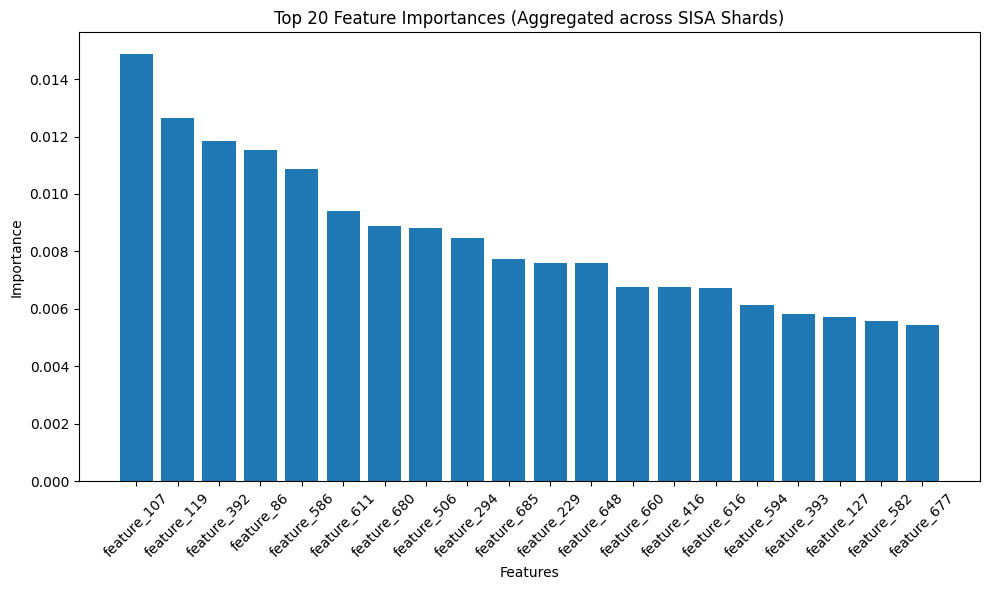

Gráfico salvo em: feature_importance.png


In [ ]:
plot_feature_importance(importance_df, top_n=20)

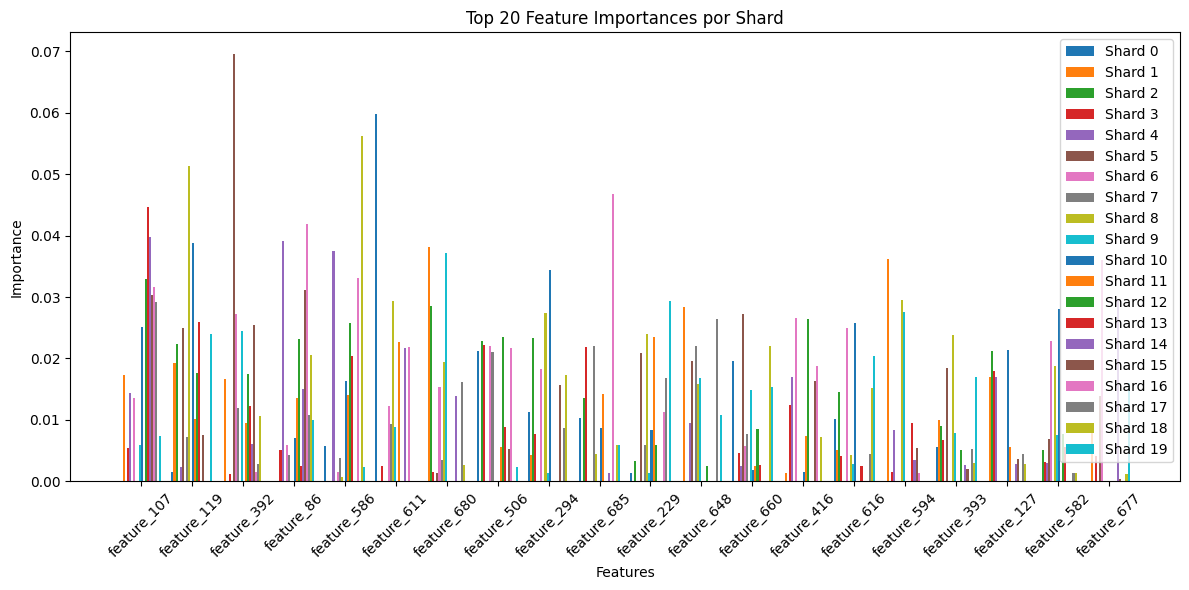

Gráfico salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/feature_importance_plots/feature_importance_by_shard.png


In [ ]:
importance_df_por_shard = get_feature_importance_sisa_mod(sisa_models_unlearned,
                                                feature_names,
                                                output_dir="/content/drive/MyDrive/Desaprendizado-de-maquina/feature_importance_plots")

In [ ]:
print(importance_df.head(20))  # Mostrar as 20 features mais importantes


         Feature  Importance
107  feature_107    0.014882
119  feature_119    0.012657
392  feature_392    0.011852
86    feature_86    0.011522
586  feature_586    0.010881
611  feature_611    0.009414
680  feature_680    0.008886
506  feature_506    0.008813
294  feature_294    0.008479
685  feature_685    0.007750
229  feature_229    0.007609
648  feature_648    0.007601
660  feature_660    0.006764
416  feature_416    0.006747
616  feature_616    0.006725
594  feature_594    0.006137
393  feature_393    0.005808
127  feature_127    0.005702
582  feature_582    0.005584
677  feature_677    0.005454


In [ ]:
importance_df_por_shard

,Feature,Aggregated_Importance,Max_Shard,Shard_0_Importance,Shard_1_Importance,Shard_2_Importance,Shard_3_Importance,Shard_4_Importance,Shard_5_Importance,Shard_6_Importance,...,Shard_10_Importance,Shard_11_Importance,Shard_12_Importance,Shard_13_Importance,Shard_14_Importance,Shard_15_Importance,Shard_16_Importance,Shard_17_Importance,Shard_18_Importance,Shard_19_Importance
107,feature_107,0.014882,13,0.000000,0.017390,0.000000,0.005397,0.014349,0.000000,0.013502,...,0.025159,0.000000,0.032907,0.044637,0.039819,0.030381,0.031564,0.029214,0.000000,0.007382
119,feature_119,0.012657,8,0.001489,0.019192,0.022284,0.000000,0.002372,0.024987,0.000000,...,0.038854,0.010184,0.017708,0.025987,0.000000,0.007567,0.000000,0.000000,0.000000,0.024025
392,feature_392,0.011852,5,0.000000,0.016613,0.000000,0.001249,0.000000,0.069621,0.027315,...,0.000000,0.009457,0.017453,0.012343,0.006090,0.025464,0.001481,0.002839,0.010577,0.000000
86,feature_86,0.011522,16,0.000000,0.000000,0.000000,0.005170,0.039099,0.000000,0.005975,...,0.007017,0.013604,0.023230,0.002568,0.014972,0.031221,0.041925,0.010833,0.020573,0.009978
586,feature_586,0.010881,18,0.005796,0.000000,0.000000,0.000000,0.037485,0.000000,0.001469,...,0.016339,0.014058,0.025754,0.020335,0.000000,0.000000,0.033107,0.000000,0.056292,0.002397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,feature_71,0.000050,19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001001
161,feature_161,0.000035,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
123,feature_123,0.000018,17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000361,0.000000,0.000000
252,feature_252,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


###Nota

Agregação: A importância das features é agregada usando a média (np.mean). Outras estatísticas ( mediana, máximo) podem ser usadas dependendo do caso. A média é comum, pois reflete a contribuição relativa de cada feature em todos os shards.
Interpretação com embeddings do BERT: As features são as dimensões do embedding ( 768 para bertimbau), que não têm interpretações semânticas diretas. Para uma análise mais interpretável, pode ser usadoo:

* Agrupar dimensões do embedding usando técnicas como PCA ou t-SNE para reduzir dimensionalidade.

* Mapeamento das dimensões mais importantes para tokens ou contextos específicos, mas isso exige análise avançada ( atenção do BERT).

* Visualização: O gráfico mostra as top_n features mais importantes. Como 768 features são muitas, limitar a visualização às 20 foi importante e tbm uma boa prática.

# Verfificação dos indices removidos nos shards

In [ ]:
def verify_structural_unlearning(indices_to_forget, shards_indices, shards_X, shards_y):
    indices_to_forget_set = set(indices_to_forget)
    for shard_idx, indices in enumerate(shards_indices):
        remaining_indices = set(indices)
        common_indices = remaining_indices.intersection(indices_to_forget_set)
        if common_indices:
            print(f"Erro: Shard {shard_idx} ainda contém índices a serem esquecidos: {common_indices}")
        else:
            print(f"Shard {shard_idx} OK: Nenhum índice a ser esquecido encontrado.")
        print(f"Shard {shard_idx} - Tamanho após unlearning: {len(shards_X[shard_idx])} amostras")



# Supondo que shards_X, shards_y, shards_indices já foram atualizados por unlearn_sisa

verify_structural_unlearning(indices_to_forget, shards_indices_unlearned, shards_X_unlearned, shards_y_unlearned)

Shard 0 OK: Nenhum índice a ser esquecido encontrado.
Shard 0 - Tamanho após unlearning: 268 amostras
Shard 1 OK: Nenhum índice a ser esquecido encontrado.
Shard 1 - Tamanho após unlearning: 269 amostras
Shard 2 OK: Nenhum índice a ser esquecido encontrado.
Shard 2 - Tamanho após unlearning: 271 amostras
Shard 3 OK: Nenhum índice a ser esquecido encontrado.
Shard 3 - Tamanho após unlearning: 267 amostras
Shard 4 OK: Nenhum índice a ser esquecido encontrado.
Shard 4 - Tamanho após unlearning: 273 amostras
Shard 5 OK: Nenhum índice a ser esquecido encontrado.
Shard 5 - Tamanho após unlearning: 270 amostras
Shard 6 OK: Nenhum índice a ser esquecido encontrado.
Shard 6 - Tamanho após unlearning: 269 amostras
Shard 7 OK: Nenhum índice a ser esquecido encontrado.
Shard 7 - Tamanho após unlearning: 272 amostras
Shard 8 OK: Nenhum índice a ser esquecido encontrado.
Shard 8 - Tamanho após unlearning: 268 amostras
Shard 9 OK: Nenhum índice a ser esquecido encontrado.
Shard 9 - Tamanho após unlea

In [ ]:
indices_presentes_nos_shards = np.array([1,10,20])

In [ ]:
verify_structural_unlearning(indices_presentes_nos_shards, shards_indices_unlearned, shards_X_unlearned, shards_y_unlearned)

Shard 0 OK: Nenhum índice a ser esquecido encontrado.
Shard 0 - Tamanho após unlearning: 268 amostras
Shard 1 OK: Nenhum índice a ser esquecido encontrado.
Shard 1 - Tamanho após unlearning: 269 amostras
Shard 2 OK: Nenhum índice a ser esquecido encontrado.
Shard 2 - Tamanho após unlearning: 271 amostras
Shard 3 OK: Nenhum índice a ser esquecido encontrado.
Shard 3 - Tamanho após unlearning: 267 amostras
Shard 4 OK: Nenhum índice a ser esquecido encontrado.
Shard 4 - Tamanho após unlearning: 273 amostras
Shard 5 OK: Nenhum índice a ser esquecido encontrado.
Shard 5 - Tamanho após unlearning: 270 amostras
Shard 6 OK: Nenhum índice a ser esquecido encontrado.
Shard 6 - Tamanho após unlearning: 269 amostras
Shard 7 OK: Nenhum índice a ser esquecido encontrado.
Shard 7 - Tamanho após unlearning: 272 amostras
Shard 8 OK: Nenhum índice a ser esquecido encontrado.
Shard 8 - Tamanho após unlearning: 268 amostras
Shard 9 OK: Nenhum índice a ser esquecido encontrado.
Shard 9 - Tamanho após unlea